In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(r'C:\Users\jinho.kim\Github\lamf_ophys_analysis_dev')
from utils import zstack_reg
import stitching_2p_fullfield
from tifffile import imread
import tifffile
from matplotlib import pyplot as plt

In [8]:
# fn = Path(r'\\allen\programs\braintv\workgroups\ophysdev\OPhysCore\operator_files\shiella_caldejon\719363\719363_V1_localized_stack_00001.tif')
fn = Path(r'\\allen\programs\mindscope\production\learning\prod1\specimen_1337214403\719363_stackretake_1px-um_300umTotal_10umstep.tif')

num_slices, num_volumes, num_columns = stitching_2p_fullfield.read_si_fullfield_metadata(fn)
fullfield_all = imread(fn)

num_rows = int((fullfield_all.shape[1]+1) / num_columns)
ind = np.hstack([np.arange(i, fullfield_all.shape[0], num_slices) for i in range(num_slices)])
fullfield_ = np.concatenate([fullfield_all[ind,:,:],np.zeros((fullfield_all.shape[0],1,fullfield_all.shape[2]))], axis=1) 
fullfield_ = fullfield_all[ind,:,:] 
fullfield_stitched = np.concatenate([np.roll(fullfield_[:, i*num_rows : (i+1)*num_rows, :], -i*12, axis=1) for i in range(num_columns)],axis=2)

In [9]:
print(fullfield_stitched.shape)
print(num_slices)
repeat = fullfield_stitched.shape[0] / num_slices
print(repeat)
assert repeat == int(repeat)
repeat = int(repeat)

(640, 2070, 2070)
32
20.0


In [10]:
ff_zstack = np.stack([fullfield_stitched[i*num_slices : (i+1)*num_slices, :, :].mean(axis=0) for i in range(repeat)])

In [11]:
save_fn_base = fn.name.split('.')[0]
save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\GCaMP8\AAV_local')
save_fn = save_dir / f'{save_fn_base}_stitched_zstack.tif'
tifffile.imwrite(save_fn, ff_zstack)


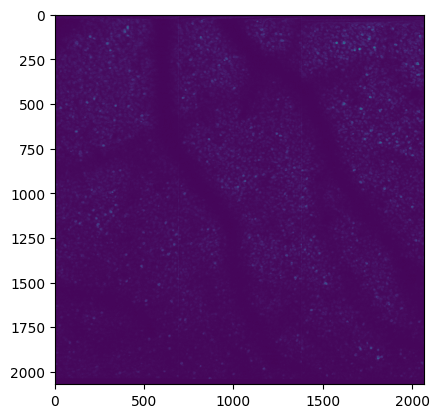

In [12]:
plt.imshow(ff_zstack[10])

In [53]:
save_fn = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\GCaMP8\AAV_local') / 'temp_stitched_zstack.tif'
tifffile.imsave(save_fn, ff_zstack)

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_7172\3830217420.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(save_fn, ff_zstack)


In [7]:
fn = Path(r'\\allen\programs\braintv\workgroups\ophysdev\OPhysCore\operator_files\shiella_caldejon\719363\719363_V1_localized_stack_00001.tif')
zstack_reg.read_si_stack_metadata(fn)

{'num_slices': 16,
 'num_volumes': 20,
 'actuator': 'fastZ',
 'num_channels': 1,
 'z_values': array([-51., -31., -11.,   9.,  29.,  49.,  69.,  89., 109., 129., 149.,
        169., 189., 209., 229., 249., 269., 289., 309., 329., 349., 369.,
        389., 409., 429., 449.])}

In [13]:
from PIL import Image
from PIL.TiffTags import TAGS
with Image.open(fn) as img:
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag_v2}


In [17]:
meta_dict['Software']

("SI.ConfigPageClass = 'dabs.resources.configuration.resourcePages.SIPage'\nSI.LINE_FORMAT_VERSION = 1\nSI.PREMIUM = true\nSI.TIFF_FORMAT_VERSION = 4\nSI.VERSION_COMMIT = '56c3afc1bf090313ec49069b93dab351ee92fd74'\nSI.VERSION_MAJOR = 2020\nSI.VERSION_MINOR = 1\nSI.VERSION_UPDATE = 4\nSI.acqState = 'grab'\nSI.acqsPerLoop = 1\nSI.errorMsg = ''\nSI.extTrigEnable = 0\nSI.fieldCurvatureRxs = []\nSI.fieldCurvatureRys = []\nSI.fieldCurvatureTilt = 0\nSI.fieldCurvatureTip = 0\nSI.fieldCurvatureZs = []\nSI.hBeams.enablePowerBox = false\nSI.hBeams.errorMsg = ''\nSI.hBeams.flybackBlanking = true\nSI.hBeams.hBeamRouters = {}\nSI.hBeams.hBeams = {'Total' 'Split'}\nSI.hBeams.hReserver = []\nSI.hBeams.hUsers = {}\nSI.hBeams.interlaceDecimation = [1 1]\nSI.hBeams.interlaceOffset = [0 0]\nSI.hBeams.lengthConstants = [900 Inf]\nSI.hBeams.name = 'SI Beams'\nSI.hBeams.powerBoxEndFrame = Inf\nSI.hBeams.powerBoxStartFrame = 1\nSI.hBeams.powerBoxes.rect = [0.25 0.25 0.5 0.5]\nSI.hBeams.powerBoxes.powers = [N

In [18]:
from ScanImageTiffReader import ScanImageTiffReader
import json
def _extract_dict_from_si_string(string):
    """Parse the 'SI' variables from a scanimage metadata string"""

    lines = string.split('\n')
    data_dict = {}
    for line in lines:
        if line.strip():  # Check if the line is not empty
            key, value = line.split(' = ')
            key = key.strip()
            if value.strip() == 'true':
                value = True
            elif value.strip() == 'false':
                value = False
            else:
                value = value.strip().strip("'")  # Remove leading/trailing whitespace and single quotes
            data_dict[key] = value

    json_data = json.dumps(data_dict, indent=2)
    loaded_data_dict = json.loads(json_data)
    return loaded_data_dict

In [19]:
with ScanImageTiffReader(str(fn)) as reader:
    md_string = reader.metadata()

# split si & roi groups, prep for seprate parse
s = md_string.split("\n{")
rg_str = "{" + s[1]
si_str = s[0]

# parse 1: extract keys and values, dump, then load again
si_metadata = _extract_dict_from_si_string(si_str)

In [20]:
si_metadata['SI.hStackManager.framesPerSlice']

'1'

In [ ]:
# fn = Path(r'\\allen\programs\braintv\workgroups\ophysdev\OPhysCore\operator_files\shiella_caldejon\719363\719363_V1_localized_stack_00001.tif')
fn = Path(r'\\allen\programs\mindscope\production\learning\prod1\specimen_1337215158\726087_V1_1px-um_350umTotal_10umStep_00001.tif ')

stitched = stitching_2p_fullfield.stitch_fullfield(fn)
plt.imshow(stitched)